# Examples using Sunpy for querying and plotting

## Querying data

In [26]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as colors

import astropy.units as u

import sunpy.map
from sunpy.net import Fido
from sunpy.net import attrs as a
import sunpy.visualization.colormaps as cm

To download the required data, we use ``sunpy.net.Fido``, a downloader client,
to query the Virtual Solar Observatory to acquire AIA and HMI data.

The following is the data available:
HMI Bands (A): 171 (gold), 193 (bronze), 304 (red), 211 (purple), 131 (teal), 335 (blue), 094 (green),
1600 (yellow/green), 1700 (pink)
HMI Products: Magnetogram, Intensitygram, Dopplergram


In [27]:
# data parameters
cadence = a.Sample(24*u.hour)  # querying cadence
start_date = '2021-1-1T12:00:00'  # start date of query
end_date = '2021-01-5T12:00:00'  # end date of query

# AIA specific parameters
aia_inst = a.Instrument.aia
# list of all available wavelengths for reference
wavelength_list = [a.Wavelength(94 * u.angstrom), a.Wavelength(131 * u.angstrom), a.Wavelength(171 * u.angstrom),
                   a.Wavelength(193 * u.angstrom), a.Wavelength(211 * u.angstrom), a.Wavelength(304 * u.angstrom),
                   a.Wavelength(335 * u.angstrom), a.Wavelength(1600 * u.angstrom), a.Wavelength(1700 * u.angstrom)]

# HMI specific parameters
hmi_inst = a.Instrument.hmi
# list of physical observables available
physobs_list = [a.Physobs.los_velocity, a.Physobs.los_magnetic_field, a.Physobs.intensity]

Now we can look at querying for specific information. We can look for results from
multiple instruments, wavelengths, and physical observables at once.

It is useful to search for results before download to ensure you don't download excessive
amounts of data.


Let's say we only want these specific results from AIA. We search for images at a 24 hour cadence between our start
and end times at specified wavelengths.

In [28]:
aia_result = Fido.search(a.Time(start_date, end_date),
                     aia_inst, wavelength_list[0]  | wavelength_list[2] | wavelength_list[3]
                     | wavelength_list[6], cadence)

We can do the same with HMI data products.

In [29]:
hmi_result = Fido.search(a.Time(start_date, end_date),
                     a.Instrument.hmi, physobs_list[0] | physobs_list[1] | physobs_list[2], cadence)


You can also query for both instruments simultaneously.

In [30]:
result = Fido.search(a.Time(start_date, end_date),
                     aia_inst | hmi_inst, wavelength_list[0] | wavelength_list[1] | wavelength_list[2] | wavelength_list[3]
                     | wavelength_list[4] | wavelength_list[5] | wavelength_list[6] | wavelength_list[7] | wavelength_list[8]
                     | physobs_list[0] | physobs_list[1] | physobs_list[2],
                     cadence)

/Users/tervin/opt/anaconda3/envs/sdo_hmi_rvs/lib/python3.8/site-packages/astropy/table/table.py:3409: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


Next we download the actual data found from our search.

In [31]:

file_download = Fido.fetch(result)


Files Downloaded:   0%|          | 0/54 [00:00<?, ?file/s]

After downloading our data, we want to sort it by date.
We then build a map sequence of our data.

In [32]:
map_seq = sunpy.map.Map(sorted(file_download))


If we want to split our results by data products.

In [33]:
aia_094, aia_131, aia_171, aia_193, aia_211, aia_304, aia_335, aia_1600, aia_1700, hmi_vel, hmi_mag, hmi_int \
    = [], [], [], [], [], [], [], [], [], [], [], []
for i, map_obj in enumerate(map_seq):
    if map_obj.meta['wavelnth'] == 94:
        aia_094.append(map_obj)
    elif map_obj.meta['wavelnth'] == 131:
        aia_131.append(map_obj)
    elif map_obj.meta['wavelnth'] == 171:
        aia_171.append(map_obj)
    elif map_obj.meta['wavelnth'] == 193:
        aia_193.append(map_obj)
    elif map_obj.meta['wavelnth'] == 211:
        aia_211.append(map_obj)
    elif map_obj.meta['wavelnth'] == 304:
        aia_304.append(map_obj)
    elif map_obj.meta['wavelnth'] == 335:
        aia_335.append(map_obj)
    elif map_obj.meta['wavelnth'] == 1600:
        aia_1600.append(map_obj)
    elif map_obj.meta['wavelnth'] == 1700:
        aia_1700.append(map_obj)
    elif map_obj.meta['wavelnth'] == 6173 and map_obj.meta['content'] == 'DOPPLERGRAM':
        hmi_vel.append(map_obj)
    elif map_obj.meta['wavelnth'] == 6173 and map_obj.meta['content'] == 'MAGNETOGRAM':
        hmi_mag.append(map_obj)
    elif map_obj.meta['wavelnth'] == 6173 and map_obj.meta['content'] == 'CONTINUUM INTENSITY':
        hmi_int.append(map_obj)

## Plotting images

You can plot individual images using inherent Sunpy features.

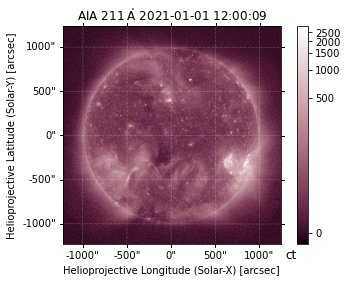

In [34]:
aia_211[0].peek()  # this plots the aia image with colorbar, axes, title

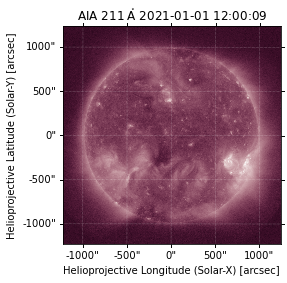

In [35]:
aia_211[0].plot()  # this just plots the data, allows you to customize
plt.show()

Plotting HMI images requires us to rotate the image to match the orientation of AIA images.

The same peek and plot methods work for HMI images.

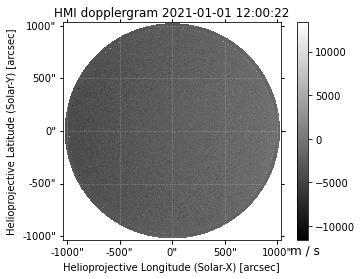

In [36]:
hmi_vel_rot = hmi_vel[0].rotate(order=3)
hmi_vel_rot.peek()

HMI images look nicer when customized a bit.

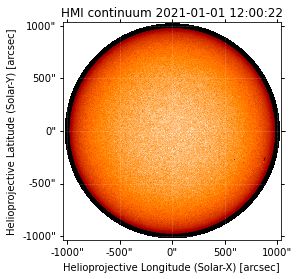

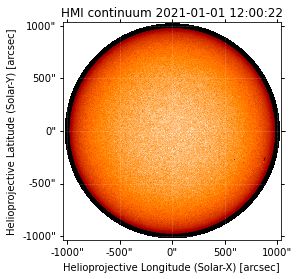

In [37]:
# plotting intensity map

int_map = hmi_int[0].rotate(order=3)
int_map.plot_settings['cmap'] = plt.get_cmap('hinodesotintensity')
fig = plt.figure()
ax = fig.add_subplot(projection=int_map)
int_map.plot(axes=ax)
plt.show()


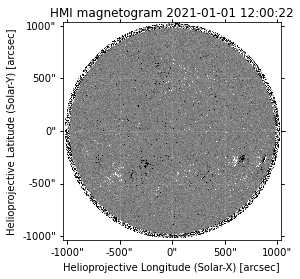

In [38]:
# plotting magnetic map

mag_map = hmi_mag[0].rotate(order=3)
mag_map.plot_settings['norm'] = plt.Normalize(-100, 100)
fig = plt.figure()
ax = fig.add_subplot(projection=mag_map)
mag_map.plot(axes=ax)
plt.show()

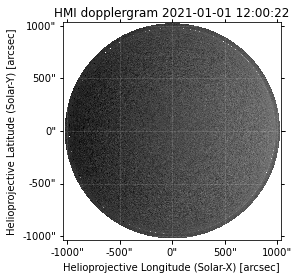

In [39]:
# plotting doppler map

vel_map = hmi_vel[0].rotate(order=3)
vel_map.plot_settings['norm'] = plt.Normalize(-5500, 5500)
fig = plt.figure()
ax = fig.add_subplot(projection=vel_map)
vel_map.plot(axes=ax)
plt.show()

We can now make some plots of multiple data types.
Don't forget to rotate HMI images such that they are oriented the same as AIA.

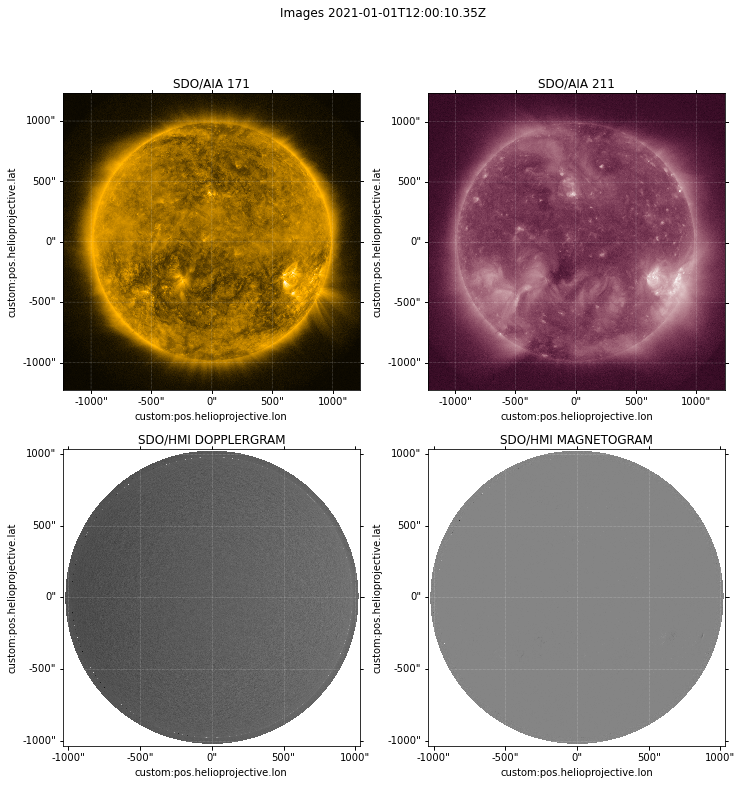

In [40]:
# rotate HMI images
hmi_vel_rot = hmi_vel[0].rotate(order=3)
hmi_mag_rot = hmi_mag[0].rotate(order=3)

# create subplots
fig = plt.figure(figsize=(12,12))
axs1 = fig.add_subplot(2, 2, 1, projection=aia_171[0])
axs2 = fig.add_subplot(2, 2, 2, projection=aia_211[0])
axs3 = fig.add_subplot(2, 2, 3, projection=hmi_vel_rot)
axs4 = fig.add_subplot(2, 2, 4, projection=hmi_mag_rot)

fig.suptitle("Images %s" % (str(aia_171[0].meta['t_obs'])))
axs1.set_title("%s %s" % (str(aia_171[0].meta['telescop']), str(aia_171[0].meta['wavelnth'])))
axs2.set_title("%s %s" % (str(aia_211[0].meta['telescop']), str(aia_211[0].meta['wavelnth'])))
axs3.set_title("%s %s" % (str(hmi_vel[0].meta['telescop']), str(hmi_vel[0].meta['content'])))
axs4.set_title("%s %s" % (str(hmi_mag[0].meta['telescop']), str(hmi_mag[0].meta['content'])))

for ax in [axs1, axs2, axs3, axs4]:
    ax.set_xticks([])
    ax.set_yticks([])

# plot data
aia_171[0].plot(axes=axs1, annotate=False)
aia_211[0].plot(axes=axs2, annotate=False)
hmi_vel_rot.plot(axes=axs3, annotate=False)
hmi_mag_rot.plot(axes=axs4, annotate=False)

plt.show()